### Prepare the notebook to have access to all files

In [1]:
import os
import sys
# get the project root
__filename__ = os.path.abspath(".")
__dirname__ = os.path.dirname(__filename__)
if __dirname__ not in sys.path:
    sys.path.append(__dirname__)

### Process library

In [2]:
from tqdm import notebook
tqdmn = notebook.tqdm

# Named Entity Recognition
This notebook gives a demonstation of how to train a model for named entity recognition. 

### Loading the Dataset

In [3]:
import numpy as np

In [4]:
def open_training_set(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.readlines()

In [5]:
def split_dataset(array):
    # find the break lines within the training dataset
    breaklines = np.where(np.array(array) == '\n')[0]
    dataset = []
    # group the sentences based on the break lines
    for i in range(breaklines.shape[0] - 1):
        start_id = breaklines[i] + 1
        end_id = breaklines[i + 1]
        dataset.append(array[start_id:end_id])
    # return the groups
    return dataset

In [6]:
def parse(string):
    [word, pos, chunk, ner] = string.strip().split(' ')
    return { 'word': word, 'pos': pos, 'chunk': chunk, 'ner': ner }

In [7]:
def format_dataset(array):
    return [[parse(row) for row in group] for group in array]

In [8]:
def prepare_dataset(filepath):
    dataset = open_training_set(filepath)
    dataset = split_dataset(dataset)
    dataset = format_dataset(dataset)
    return dataset

In [11]:
train_path = "../data/ner/train.txt"
valid_path = "../data/ner/valid.txt"
test_path = "../data/ner/test.txt"

train = prepare_dataset(train_path)
valid = prepare_dataset(valid_path)
test = prepare_dataset(test_path)

In [12]:
# checking the format used to generate the input tensors
# NOTE: this format is only used for training, afterwards we will see 
# how to use the model on a whole sentence
train[0]

[{'word': 'EU', 'pos': 'NNP', 'chunk': 'B-NP', 'ner': 'B-ORG'},
 {'word': 'rejects', 'pos': 'VBZ', 'chunk': 'B-VP', 'ner': 'O'},
 {'word': 'German', 'pos': 'JJ', 'chunk': 'B-NP', 'ner': 'B-MISC'},
 {'word': 'call', 'pos': 'NN', 'chunk': 'I-NP', 'ner': 'O'},
 {'word': 'to', 'pos': 'TO', 'chunk': 'B-VP', 'ner': 'O'},
 {'word': 'boycott', 'pos': 'VB', 'chunk': 'I-VP', 'ner': 'O'},
 {'word': 'British', 'pos': 'JJ', 'chunk': 'B-NP', 'ner': 'B-MISC'},
 {'word': 'lamb', 'pos': 'NN', 'chunk': 'I-NP', 'ner': 'O'},
 {'word': '.', 'pos': '.', 'chunk': 'O', 'ner': 'O'}]

## Preparing the Model Variables

In [127]:
# entity-index mapping
entities = {
    "O": 0,
    "B-ORG": 1,
    "B-MISC": 2,
    "B-LOC": 3,
    "B-PER": 4,
    "I-ORG": 5,
    "I-MISC": 6,
    "I-LOC": 7,
    "I-PER": 8
}

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training Hyperparameters

In [15]:
# assign the training parameters

# n_epochs tells how many times we go through the training dataset
n_epochs = 5
# batch_size tells how many examples we view before we do back-propagation
batch_size = 64

## Initializing the NER Model

In [16]:
from library.xlm_roberta_ner import XLMRobertaNER

In [17]:
# assign the initialization configurations
config = { "entities": entities }
# NER model 
# NOTE: this line will initialize the NER model, move it to GPU (if "cuda" is available), 
# and set it into training mode (this is important because XLM-Roberta has a dropout component)
ner = XLMRobertaNER(config).to(device).train()
# assign the training parameters
optimizer = optim.Adam(ner.parameters(), lr=1e-5)

In [18]:
def evaluate_model(ner, dataset):
    """Gets the average loss score of the model on the given dataset

    Args:
        ner (torch.nn.Module): The NER model that is being evaluated.
        dataset (List[Dict[str, str]]): The dataset on which the model is being evaluated.

    Returns:
        number: The average loss value over the whole dataset.

    """
    total_loss = 0.0
    for example in dataset:
        tokens_tensor, attention_mask_tensor, labels_tensor = ner.get_train_tokens_attention_labels_tensor(example)
        # get the final output
        tokens_tensor = tokens_tensor.to(device)
        attention_mask_tensor = attention_mask_tensor.to(device)
        labels_tensor = labels_tensor.to(device)
        # calculate the loss and scores
        with torch.no_grad():
            (loss, scores, entities, tokens, labels) = ner(tokens_tensor, attention_mask_tensor=attention_mask_tensor, labels_tensor=labels_tensor)
        
        # clean the tensors that are not used anymore
        del tokens_tensor
        del attention_mask_tensor
        del labels_tensor

        # get the loss value 
        total_loss += loss.item()
        
    # return the evaluation loss
    return total_loss / len(dataset)

In [19]:
def train_model(ner, device, optimizer, n_epochs, batch_size, loss_values=None, eval_values=None):
    """Trains the model with the given parameters

    Args:
        ner (torch.nn.Module): The NER model that is going to be trained.
        device (torch.device): The pytorch device object. Where the training is going to be performed.
        optimizer (torch.optim): The optimizer used to train the model.
        n_epochs (int): The number of epochs we train the model.
        batch_size (int): The number of examples we first view before we update the model.
        loss_values (List[float]): The loss values placeholder. Used to visualize the loss values (Default: None).
        eval_values (List[float]): The evaluation values placeholder. Used to visualize the evaluation values (Default: None).
    """

    # iterate through the training dataset 'n_epochs'-times
    for i in tqdmn(range(n_epochs), desc="Epochs"):
        # initialize the metrics
        count_iter = 0
        total_loss = 0.0
        # initialize the models gradients
        optimizer.zero_grad()

        # prepare the data
        for example in tqdmn(train, desc="Examples"):
            # generate the input tensors from the example
            tokens_tensor, attention_mask_tensor, labels_tensor = ner.get_train_tokens_attention_labels_tensor(example)
            
            # move the tensors to the device
            tokens_tensor = tokens_tensor.to(device)
            attention_mask_tensor = attention_mask_tensor.to(device)
            labels_tensor = labels_tensor.to(device)

            # calculate the loss and scores
            (loss, scores, entities, tokens, labels) = ner(tokens_tensor, attention_mask_tensor=attention_mask_tensor, labels_tensor=labels_tensor)
            
            # update the gradients
            loss.backward()
            
            # clean the tensors that are not used anymore
            del tokens_tensor
            del attention_mask_tensor
            del labels_tensor
            
            # get the loss value 
            total_loss += loss.item()
            count_iter += 1
            
            # remove the loss value
            del loss

            if count_iter % batch_size == 0:
                if loss_values != None:
                    # store the average training loss value
                    loss_values.append(total_loss / count_iter)

                # update the NER model
                optimizer.step()
                total_loss = 0.0
                count_iter = 0
                optimizer.zero_grad()
                
                if eval_values != None:
                    # get intermediate evaluation score on the validation dataset
                    eval_values.append(evaluate_model(ner, valid))
                
        # update the model one last time
        optimizer.step()
        # remove the gradients
        optimizer.zero_grad()

        if loss_values != None:
            # store the average training loss value
            loss_values.append(total_loss / count_iter)

        if eval_values != None:
            # get intermediate evaluation score on the validation dataset
            eval_values.append(evaluate_model(ner, valid))

In [20]:
# initialize the loss and evaluation value containers
loss_values = []
eval_values = []

In [ ]:
# start the model training process
# NOTE: if `eval_values` is present it will take much longer to train. If you are not interested in
# intermediate evaluations, set the `eval_values` to `None`
train_model(ner, device, optimizer, n_epochs, batch_size, loss_values=loss_values, eval_values=eval_values)

### Visualize the loss values

In [56]:
# import the loss_plot function to visualize the distributions
from library.visualizations import loss_plots, heatmap

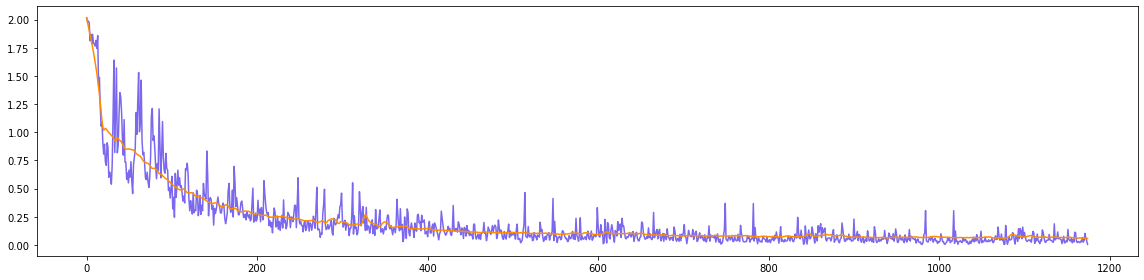

In [28]:
loss_plots([loss_values, eval_values], figsize=(16, 4))

In [29]:
# calculate the average loss value on the training dataset
avg_loss_train = sum(loss_values) / len(loss_values)
print("Training Loss:", avg_loss_train)

Training Loss: 0.20407677278601535


In [30]:
# calculate the average loss value on the validation dataset
avg_loss_valid = sum(eval_values) / len(eval_values)
print("Evaluation Loss:", avg_loss_valid)

Evaluation Loss: 0.2047235881079285


## Evaluating on the Test Dataset

In [50]:
def evaluate_model_test(ner):
    """Gets the average loss score of the model on the test dataset

    Args:
        ner (torch.nn.Module): The NER model that is being evaluated.

    Returns:
        loss (int): The average loss value over the whole dataset.
        coocurrence (dict): The coocurrence of the true and predicted labels.
    """
    
    coocurrence = { key1: { key2: 0 for key2 in entities.keys() } for key1 in entities.keys() }
    total_loss = 0
    for example in tqdmn(test, desc="Test"):
        tokens_tensor, attention_mask_tensor, labels_tensor = ner.get_train_tokens_attention_labels_tensor(example)
        # get the final output
        tokens_tensor = tokens_tensor.to(device)
        attention_mask_tensor = attention_mask_tensor.to(device)
        labels_tensor = labels_tensor.to(device)
        # calculate the loss and scores
        with torch.no_grad():
            (loss, scores, _, _, labels) = ner(tokens_tensor, attention_mask_tensor=attention_mask_tensor, labels_tensor=labels_tensor)
        
        # clean the tensors that are not used anymore
        del tokens_tensor
        del attention_mask_tensor
        del labels_tensor

        # get the loss value 
        total_loss += loss.item()
        
        true_labels = [word["ner"] for word in example]
        for true, pred in list(zip(true_labels, labels[1:-1])):
            coocurrence[true][pred] += 1
        
    # return the evaluation loss and the coocurrence
    return (total_loss / len(test), coocurrence)

In [51]:
# get the average loss and coocurrence 
loss, coocurrence = evaluate_model_test(ner)

## Statistics

In [67]:
# converting the coocurrence dictionary to a matrix
count = np.array([
    [val for key, val in coocurrence[key].items()] 
    for key in coocurrence.keys()
])

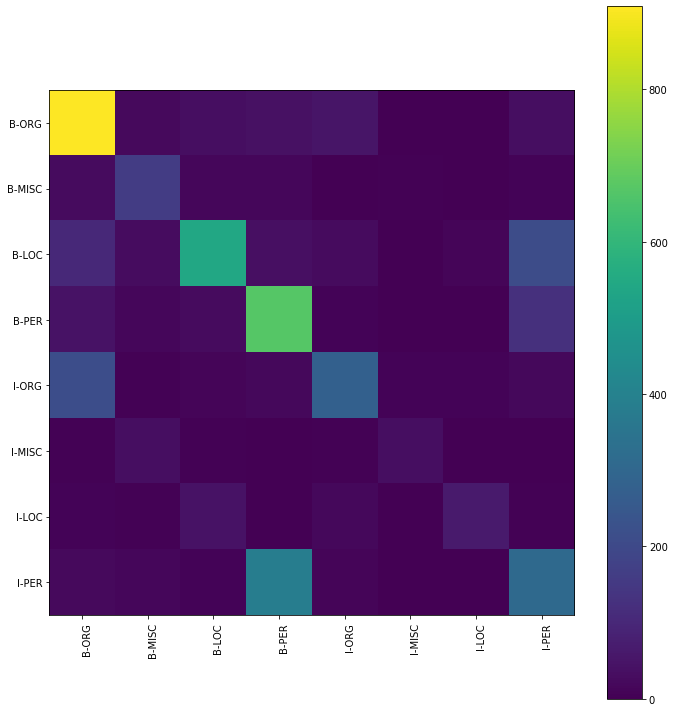

In [193]:
# ignore other as it is the dominant tag
start_id = 1
# show the heatmap of the coocurrence matrix
heatmap(count[start_id:,start_id:], x_tick_labels=list(entities.keys())[start_id:], y_tick_labels=list(entities.keys())[start_id:])

In [194]:
# merge the B- and I- tags of the same group
labels = ["OTHER", "ORGANIZATION", "MISCELLANEOUS", "LOCATION", "PERSON"]
merged_count = np.array([
    [
        count[0][0], 
        count[0][1] + count[0][5], 
        count[0][2] + count[0][6], 
        count[0][3] + count[0][7], 
        count[0][4] + count[0][8]
    ],
    [
        count[1][0]               + count[5][0], 
        count[1][1] + count[1][5] + count[5][1] + count[5][5], 
        count[1][2] + count[1][6] + count[5][2] + count[5][6], 
        count[1][3] + count[1][7] + count[5][3] + count[5][7], 
        count[1][4] + count[1][8] + count[5][4] + count[5][8]
    ],
    [
        count[2][0]               + count[6][0], 
        count[2][1] + count[2][5] + count[6][1] + count[6][5], 
        count[2][2] + count[2][6] + count[6][2] + count[6][6], 
        count[2][3] + count[2][7] + count[6][3] + count[6][7], 
        count[2][4] + count[2][8] + count[6][4] + count[6][8]
    ],
    [
        count[3][0]               + count[7][0], 
        count[3][1] + count[3][5] + count[7][1] + count[7][5], 
        count[3][2] + count[3][6] + count[7][2] + count[7][6], 
        count[3][3] + count[3][7] + count[7][3] + count[7][7], 
        count[3][4] + count[3][8] + count[7][4] + count[7][8]
    ],
    [
        count[4][0]               + count[8][0], 
        count[4][1] + count[4][5] + count[8][1] + count[8][5], 
        count[4][2] + count[4][6] + count[8][2] + count[8][6], 
        count[4][3] + count[4][7] + count[8][3] + count[8][7], 
        count[4][4] + count[4][8] + count[8][4] + count[8][8]
    ]
    
])

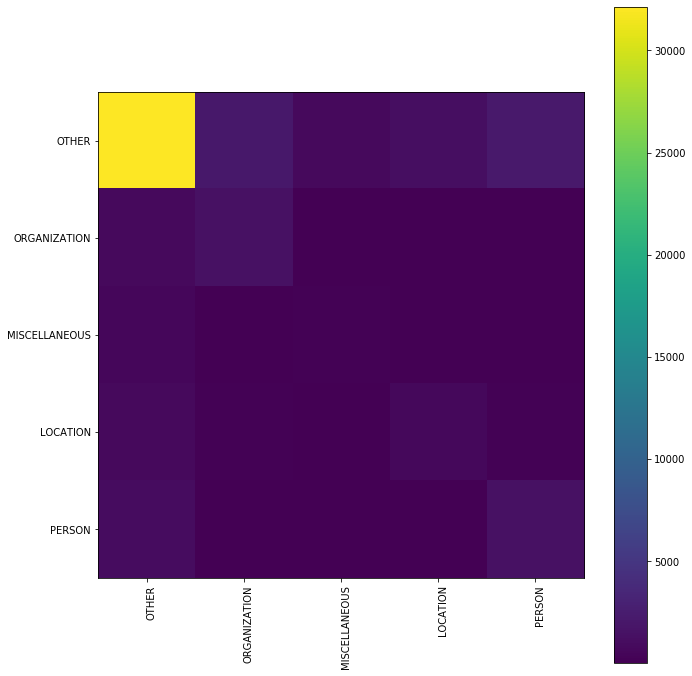

In [200]:
# again ignore the other label
start_id = 0
# show the heatmap of the coocurrence matrix
heatmap(merged_count[start_id:,start_id:], x_tick_labels=labels[start_id:], y_tick_labels=labels[start_id:])

#### Statistics

In [197]:
# accuracy over all predictions
tp = merged_count.diagonal().sum()
all = np.sum(merged_count)
print("Accuracy (all predictions):", tp / all)

Accuracy (all predictions): 0.7718985929993136


In [201]:
# precision
start_id = 0

for i, label in enumerate(labels[start_id:]):
    row = merged_count[start_id:, start_id:][i]
    col = merged_count[start_id:, start_id:][:, i]
    
    prec = row[i] / np.sum(row)
    recl = col[i] / np.sum(col)
    f1 = 2 * (prec * recl) / (prec + recl)
    
    print(label)
    print("------------------------------")
    print("Precision: {}".format(prec))
    print("Recall   : {}".format(recl))
    print("F1       : {}".format(f1))
    print("\n")    

OTHER
------------------------------
Precision: 0.8342116877385186
Recall   : 0.9061504187699162
F1       : 0.8686942416869424


ORGANIZATION
------------------------------
Precision: 0.5838011226944667
Recall   : 0.37847673511827395
F1       : 0.4592335593754928


MISCELLANEOUS
------------------------------
Precision: 0.25901639344262295
Recall   : 0.19865884325230512
F1       : 0.2248576850094877


LOCATION
------------------------------
Precision: 0.3492723492723493
Recall   : 0.3323442136498516
F1       : 0.34059807399898634


PERSON
------------------------------
Precision: 0.5378787878787878
Recall   : 0.3635698610095099
F1       : 0.43387167175905716




## Using the Model on a sentence in different language

In [94]:
# NOTE: before using the model, one must first put it into evaluation mode
# to turn off the Dropout component used during training
ner = ner.eval()

In [95]:
# generate the tokens and attention mask tensors on the given text
text = "Erik Novak je raziskovalec na Inštitutu Jožef Stefan v Ljubljani, Sloveniji."
# NOTE: here we use the `tokenization` function (different from the function used durring training)
tokens_tensor, attention_mask_tensor  = ner.tokenization(text)

In [97]:
# move the tensors to the device
tokens_tensor = tokens_tensor.to(device)
attention_mask_tensor = attention_mask_tensor.to(device)
# do not calculate the gradients (to reduce the model size)
with torch.no_grad():
    # get the model predictions
    (loss, scores, ent, tokens, labels) = ner(tokens_tensor, attention_mask_tensor)

In [98]:
# output the entity tokens and tags
ent

[('Erik', 'B-PER'),
 ('Novak', 'I-PER'),
 ('je', 'O'),
 ('raziskovalec', 'O'),
 ('na', 'O'),
 ('Inštitutu', 'B-ORG'),
 ('Jožef', 'I-ORG'),
 ('Stefan', 'I-ORG'),
 ('v', 'O'),
 ('Ljubljani', 'B-LOC'),
 (',', 'O'),
 ('Sloveniji', 'B-LOC'),
 ('.', 'O')]

## Save the Model

In [101]:
# set the model store path
model_path = "../data/models/xlm_roberta_ner_conell_2003.pth"

In [116]:
# the model is saved using the pytorch library
torch.save({
    'entities': ner.to("cpu").entities,
    'model_state_dict': ner.to("cpu").state_dict()
}, model_path)

## Load the Model

In [117]:
# get the model parameters
model_parameters = torch.load(model_path)

In [119]:
# first initialize the model (similarly as before training)
config = {
    "entities": model_parameters["entities"]
}
ner2 = XLMRobertaNER(config)

In [120]:
# then load the model parameters
ner2.load_state_dict(model_parameters['model_state_dict'])

<All keys matched successfully>

In [121]:
# NOTE: before using the model, one must first put it into evaluation mode
# to turn off the Dropout component used during training
ner2 = ner2.eval()

In [122]:
# generate the tokens and attention mask tensors on the given text
text = "Erik Novak je raziskovalec na Inštitutu Jožef Stefan v Ljubljani, Sloveniji."
# NOTE: here we use the `tokenization` function (different from the function used durring training)
tokens_tensor, attention_mask_tensor  = ner2.tokenization(text)

In [123]:
# do not calculate the gradients (to reduce the model size)
with torch.no_grad():
    # get the model predictions
    (loss, scores, ent, tokens, labels) = ner2(tokens_tensor, attention_mask_tensor)

In [124]:
# output the entity tokens and tags
ent

[('Erik', 'B-PER'),
 ('Novak', 'I-PER'),
 ('je', 'O'),
 ('raziskovalec', 'O'),
 ('na', 'O'),
 ('Inštitutu', 'B-ORG'),
 ('Jožef', 'I-ORG'),
 ('Stefan', 'I-ORG'),
 ('v', 'O'),
 ('Ljubljani', 'B-LOC'),
 (',', 'O'),
 ('Sloveniji', 'B-LOC'),
 ('.', 'O')]